## 1. Custom Dataset class

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
class LinearDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
# Reuse data from Day 4
torch.manual_seed(42)
X = torch.linspace(0, 10, 100).unsqueeze(1)
y = 3 * X + 2 + 0.1 * torch.randn_like(X)

In [4]:
dataset = LinearDataset(X, y)
print("Dataset length:", len(dataset))
print("Sample:", dataset[0])

Dataset length: 100
Sample: (tensor([0.]), tensor([2.1927]))


## 2. DataLoader (batching + shuffling)

In [5]:
# Create batches
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,     # Important for training!
    num_workers=0     # Set >0 if multiprocessing works
)

print("Number of batches:", len(dataloader))

Number of batches: 7


In [6]:
# Inspect one batch
for X_batch, y_batch in dataloader:
    print("Batch X shape:", X_batch.shape)
    print("Batch y shape:", y_batch.shape)
    break

Batch X shape: torch.Size([16, 1])
Batch y shape: torch.Size([16, 1])


## 3. Reuse of Day 4 model

In [7]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.nn.Parameter(torch.randn(1))
        self.b = torch.nn.Parameter(torch.randn(1))

    def forward(self, x):
        return self.w * x + self.b

In [8]:
model = LinearModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## 4. Epoch training loop with batches

In [9]:
def train_with_dataloader(model, dataloader, criterion, optimizer, epochs=100):
    model.train()  # Sets training mode

    all_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0

        # Loop over batches
        for X_batch, y_batch in dataloader:
            # Forward
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        all_losses.append(avg_loss)

        if epoch % 20 == 0:
            print(f"Epoch {epoch:3d}, Avg Loss: {avg_loss:.4f}")

    return all_losses

# Train!
losses = train_with_dataloader(model, dataloader, criterion, optimizer, epochs=200)

print(f"Final w: {model.w.item():.2f}, b: {model.b.item():.2f}")

Epoch   0, Avg Loss: 16.5827
Epoch  20, Avg Loss: 0.1849
Epoch  40, Avg Loss: 0.0558
Epoch  60, Avg Loss: 0.0203
Epoch  80, Avg Loss: 0.0116
Epoch 100, Avg Loss: 0.0124
Epoch 120, Avg Loss: 0.0096
Epoch 140, Avg Loss: 0.0094
Epoch 160, Avg Loss: 0.0101
Epoch 180, Avg Loss: 0.0106
Final w: 3.00, b: 2.01


## 5. Evaluation mode + full dataset prediction

In [10]:
# Switch to eval mode
model.eval()
with torch.no_grad():
    y_pred_full = model(X)
    final_loss = criterion(y_pred_full, y)

print("Final full-dataset loss:", final_loss.item())

Final full-dataset loss: 0.01039321068674326


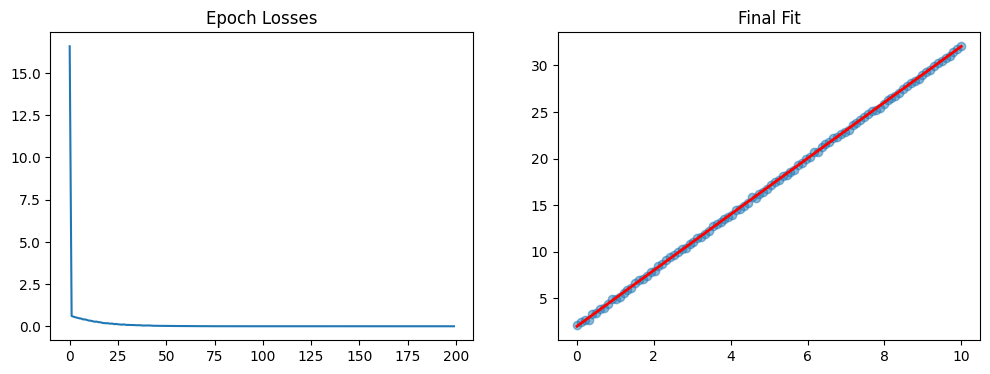

In [11]:
# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Epoch Losses")
plt.subplot(1, 2, 2)
plt.scatter(X, y, alpha=0.5)
plt.plot(X, y_pred_full, "r-", linewidth=2)
plt.title("Final Fit")
plt.show()

## 6. Train/val split

In [12]:
from torch.utils.data import random_split

In [13]:
# Split 80/20
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

Train batches: 5
Val batches: 2


7. Train/val loop

In [14]:
def train_validate_loop(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for Xb, yb in train_loader:
            y_pred = model(Xb)
            loss = criterion(y_pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation (no gradients!)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                y_pred = model(Xb)
                val_loss += criterion(y_pred, yb).item()

        print(f"Epoch {epoch:3d}: Train {train_loss/len(train_loader):.4f}, Val {val_loss/len(val_loader):.4f}")